# imbalanced-learn

[imbalanced-learn](https://imbalanced-learn.org) is a package to deal with imbalance in data. The data imbalance typically manifest when you have data with class labels, and one or more of these classes suffers from having too few examples to learn from. `imbalanced-learn` has three broad categories of approaches to deal with class imbalance.

- oversampling: oversample the minority class
- understampling: undersample the majority class
- combination: use a combination of oversampling and undersampling

Let's investigate the use of each of these approaches in dealing with the class imbalance problem.

## Data generation

Here, we will create a dataset using Scikit-Learn's `make_classification()` method. There will be only 2 classes, and as you will see, the samples per class that are about the same amount.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd

plt.style.use('ggplot')
np.random.seed(37)

X, y = make_classification(**{
    'n_samples': 5000,
    'n_features': 5,
    'n_classes': 2,
    'random_state': 37
})

columns = [f'x{i}' for i in range(X.shape[1])] + ['y']
df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]), columns=columns)

print(df.shape)

(5000, 6)


In [2]:
df.head()

,x0,x1,x2,x3,x4,y
0,-0.729402,0.390517,-0.603771,0.286312,-0.266412,0.0
1,0.030495,-0.970299,1.223902,-0.343972,-0.479884,0.0
2,-0.657696,-0.811643,-1.075159,0.405169,-0.022806,0.0
3,0.138540,2.012018,-1.825350,0.482964,0.845321,1.0
4,2.231350,-0.705512,-0.453736,-0.238611,1.757486,1.0


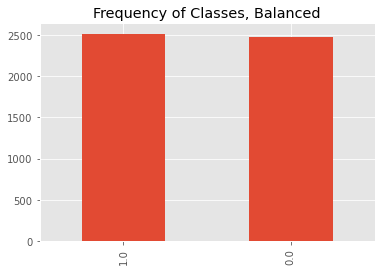

In [3]:
ax = df.y.value_counts().plot(kind='bar')
_ = ax.set_title('Frequency of Classes, Balanced')

## Class imbalance

We will then transform the data so that class 0 is the majority class and class 1 is the minority class. Class 1 will have only 1% of what was originally generated.

In [4]:
df0 = df[df.y == 0].copy(deep=True).reset_index(drop=True)
df1 = df[df.y == 1].sample(frac=0.01).copy(deep=True).reset_index(drop=True)

df = pd.concat([df0, df1])

In [5]:
df.shape

(2508, 6)

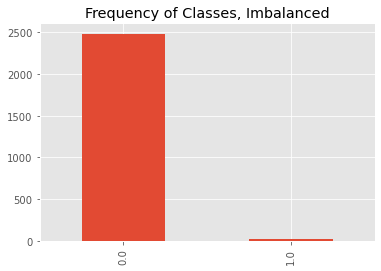

In [6]:
ax = df.y.value_counts().plot(kind='bar')
_ = ax.set_title('Frequency of Classes, Imbalanced')

## Learning with class imbalance

We will use a random forest classifier to learn from the imbalanced data. The learning will be validated using a stratified k=10 fold approach. We will also benchmark the performance of the random forest classifier using `Area Under the Curve` (auc) and `Average Precision Score` (aps).

In [7]:
X = df[[c for c in df.columns if c != 'y']]
y = df.y

print(X.shape, y.shape)

(2508, 5) (2508,)


In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=37)

rdf = []
for fold, (tr, te) in enumerate(skf.split(X, y)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    
    model = LogisticRegression(penalty='l2', solver='liblinear', random_state=37)
    model = RandomForestClassifier(n_jobs=-1, random_state=37)
    model.fit(X_tr, y_tr)
    y_pr = model.predict_proba(X_te)[:,1]
    
    auc = roc_auc_score(y_te, y_pr)
    aps = average_precision_score(y_te, y_pr)
    
    rdf.append({'auc': auc, 'aps': aps})
    
rdf = pd.DataFrame(rdf)

In [9]:
rdf[['auc', 'aps']].agg(['mean', 'std'])

,auc,aps
mean,0.972218,0.750400
std,0.080609,0.305972


## Oversampling

Below are the results of applying multiple oversampling techniques with random forest classification validated by stratified, k-fold cross-validation.

In [10]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.cluster import KMeans
from collections import Counter
from itertools import chain

def get_oversampler(sampler):
    if 'adasyn' == sampler:
        p = {
            'random_state': 37,
            'n_neighbors': 5
        }
        return ADASYN(**p)
    elif 'borderlinesmote' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1,
            'k_neighbors': 5,
            'm_neighbors': 10
        }
        return BorderlineSMOTE(**p)
    elif 'svmsmote' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1,
            'k_neighbors': 5,
            'm_neighbors': 10
        }
        return SVMSMOTE(**p)
    elif 'kmeanssmote' == sampler:
        kmeans = KMeans(n_clusters=5, random_state=37)
        p = {
            'random_state': 37,
            'n_jobs': -1,
            'k_neighbors': 5,
            'kmeans_estimator': kmeans
        }
        return KMeansSMOTE(**p)
    elif 'random' == sampler:
        p = {
            'random_state': 37
        }
        return RandomOverSampler(**p)
    else:
        p = {
            'random_state': 37,
            'k_neighbors': 5
        }
        return SMOTE(**p)

def get_results(sampler, f):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=37)

    results = []
    for fold, (tr, te) in enumerate(skf.split(X, y)):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        counts = sorted(Counter(y_tr).items())
        n_0, n_1 = counts[0][1], counts[1][1]

        if sampler != 'none':
            sampling_approach = f(sampler)
            X_tr, y_tr = sampling_approach.fit_resample(X_tr, y_tr)

        # model = LogisticRegression(penalty='l2', solver='liblinear', random_state=37)
        model = RandomForestClassifier(n_jobs=-1, random_state=37)
        model.fit(X_tr, y_tr)
        y_pr = model.predict_proba(X_te)[:,1]

        auc = roc_auc_score(y_te, y_pr)
        aps = average_precision_score(y_te, y_pr)

        counts = sorted(Counter(y_tr).items())
        r_0, r_1 = counts[0][1], counts[1][1]

        results.append({
            'sampler': sampler,
            'auc': auc, 
            'aps': aps, 
            'n_maj': n_0, 
            'r_maj': r_0, 
            'n_min': n_1, 
            'r_min': r_1
        })
        
    return results

In [11]:
%%time

samplers = ['none', 'random', 'smote', 'adasyn', 'borderlinesmote', 'svmsmote']
odf = pd.DataFrame(list(chain(*[get_results(s, get_oversampler) for s in samplers])))

Wall time: 15 s


In [12]:
odf[['sampler', 'auc', 'aps']].groupby('sampler').agg(['mean', 'std'])

auc                 aps          
                     mean       std      mean       std
sampler                                                
adasyn           0.971713  0.080083  0.748178  0.222613
borderlinesmote  0.971511  0.080007  0.734289  0.206186
none             0.972218  0.080609  0.750400  0.305972
random           0.972351  0.079962  0.778178  0.242363
smote            0.972014  0.079815  0.759844  0.204722
svmsmote         0.971881  0.080504  0.739844  0.278877

## Undersampling

Below are the results of applying multiple undersampling techniques with random forest classification validated by stratified, k-fold cross-validation.

In [13]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule, InstanceHardnessThreshold

def get_undersampler(sampler):
    if 'random' == sampler:
        p = {
            'random_state': 37
        }
        return RandomUnderSampler(**p)
    elif 'nearmiss1' == sampler:
        p = {
            'version': 1,
            'n_jobs': -1
        }
        return NearMiss(**p)
    elif 'nearmiss2' == sampler:
        p = {
            'version': 2,
            'n_jobs': -1
        }
        return NearMiss(**p)
    elif 'nearmiss3' == sampler:
        p = {
            'version': 3,
            'n_jobs': -1
        }
        return NearMiss(**p)
    elif 'editednn' == sampler:
        p = {
            'n_jobs': -1
        }
        return EditedNearestNeighbours(**p)
    elif 'reditednn' == sampler:
        p = {
            'n_jobs': -1
        }
        return RepeatedEditedNearestNeighbours(**p)
    elif 'condensednn' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1
        }
        return CondensedNearestNeighbour(**p)
    elif 'onesided' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1
        }
        return OneSidedSelection(**p)
    elif 'neighcleanrule' == sampler:
        p = {
            'n_jobs': -1
        }
        return NeighbourhoodCleaningRule(**p)
    elif 'instancehardthresh' == sampler:
        estimator = LogisticRegression(solver='lbfgs', multi_class='auto')
        p = {
            'estimator': estimator,
            'random_state': 37,
            'n_jobs': -1
        }
        return InstanceHardnessThreshold(**p)

In [14]:
%%time

samplers = ['random', 'nearmiss1', 'nearmiss2', 
            'nearmiss3', 'editednn', 'reditednn', 'condensednn',
            'onesided', 'neighcleanrule']
udf = pd.DataFrame(list(chain(*[get_results(s, get_undersampler) for s in samplers])))

Wall time: 48.4 s


In [15]:
udf[['sampler', 'auc', 'aps']].groupby('sampler').agg(['mean', 'std'])

auc                 aps          
                    mean       std      mean       std
sampler                                               
condensednn     0.994261  0.010101  0.746438  0.278687
editednn        0.971847  0.081873  0.745956  0.281920
nearmiss1       0.991982  0.007731  0.661993  0.202126
nearmiss2       0.992929  0.009534  0.678327  0.251700
nearmiss3       0.991876  0.015964  0.727037  0.274334
neighcleanrule  0.972518  0.081746  0.808733  0.265511
onesided        0.971445  0.082091  0.714289  0.278155
random          0.996172  0.006600  0.792222  0.225959
reditednn       0.972047  0.081932  0.767622  0.258529

## Combination

Below are the results of applying multiple combination techniques with random forest classification validated by stratified, k-fold cross-validation.

In [16]:
from imblearn.combine import SMOTEENN, SMOTETomek

def get_combine(sampler):
    if 'smoteenn' == sampler:
        p = {
            'random_state': 37,
            'k_neighbors': 5
        }
        smote = SMOTE(**p)
    
        p = {
            'n_jobs': -1
        }
        enn = EditedNearestNeighbours(**p)
        
        p = {
            'smote': smote,
            'enn': enn,
            'n_jobs': -1,
            'random_state': 37
        }
        return SMOTEENN(**p)
    elif 'smotetomek' == sampler:
        p = {
            'random_state': 37,
            'k_neighbors': 5
        }
        smote = SMOTE(**p)
        
        p = {
            'smote': smote,
            'random_state': 37,
            'n_jobs': -1
        }
        return SMOTETomek(**p)

In [17]:
%%time

samplers = ['smoteenn', 'smotetomek']
cdf = pd.DataFrame(list(chain(*[get_results(s, get_combine) for s in samplers])))

Wall time: 5.35 s


In [18]:
cdf[['sampler', 'auc', 'aps']].groupby('sampler').agg(['mean', 'std'])

auc                 aps          
                mean       std      mean       std
sampler                                           
smoteenn    0.971678  0.080401  0.726511  0.241162
smotetomek  0.972014  0.079815  0.759844  0.204722

## Comparisons

Here, we will compare the results of all sampling approaches.

In [19]:
odf['type'] = odf.sampler.apply(lambda s: 'baseline' if s == 'none' else 'over')
udf['type'] = 'under'
cdf['type'] = 'combo'

rdf = pd.concat([odf, udf, cdf]).reset_index(drop=True)

As you can see below, 

- all sampling techniques do about the same in terms of `AUC`,
- the differences is with the `APS` performance,
- undersampling with neighborhood cleaning rule seems to do the best, and
- surprisingly, no sampling is still competitive.

In [20]:
sort = [('aps', 'mean'), ('aps', 'std'), ('auc', 'mean'), ('auc', 'std')]
rdf[['sampler', 'type', 'auc', 'aps']]\
    .groupby(['type', 'sampler'])\
    .agg(['mean', 'std'])\
    .sort_values(sort, ascending=False)

auc                 aps          
                              mean       std      mean       std
type     sampler                                                
under    neighcleanrule   0.972518  0.081746  0.808733  0.265511
         random           0.996172  0.006600  0.792222  0.225959
over     random           0.972351  0.079962  0.778178  0.242363
under    reditednn        0.972047  0.081932  0.767622  0.258529
combo    smotetomek       0.972014  0.079815  0.759844  0.204722
over     smote            0.972014  0.079815  0.759844  0.204722
baseline none             0.972218  0.080609  0.750400  0.305972
over     adasyn           0.971713  0.080083  0.748178  0.222613
under    condensednn      0.994261  0.010101  0.746438  0.278687
         editednn         0.971847  0.081873  0.745956  0.281920
over     svmsmote         0.971881  0.080504  0.739844  0.278877
         borderlinesmote  0.971511  0.080007  0.734289  0.206186
under    nearmiss3        0.991876  0.015964  0.727037  0.274334
combo    smoteenn         0.971678  0.080401  0.726511  0.241162
under    onesided         0.971445  0.082091  0.714289  0.278155
         nearmiss2        0.992929  0.009534  0.678327  0.251700
         nearmiss1        0.991982  0.007731  0.661993  0.202126

## Pipeline

If you need to use one of the samplers in a pipeline, do not use `sklearn.pipeline.Pipeline`, instead, use `imblearn.pipeline`, which is a drop-in replacement. Here's an example of a learning pipeline with hyperparameter tuning.

In [21]:
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

def get_model(n_splits=5):
    cv = StratifiedKFold(**{
        'n_splits': n_splits,
        'shuffle': True,
        'random_state': 37
    })

    auc_scorer = make_scorer(
        roc_auc_score, 
        greater_is_better=True, 
        needs_proba=True, 
        multi_class='ovo')

    scoring = {
      'auc': auc_scorer
    }

    scaler = MinMaxScaler()
    sampler = ADASYN(**{
        'random_state': 37,
        'n_jobs': -1
    })
    classifier = RandomForestClassifier(**{
        'random_state': 37,
        'n_jobs': -1,
        'verbose': 0
    })

    pipeline = Pipeline([
        ('scaler', scaler),
        ('sampler', sampler),
        ('classifier', classifier)
    ])

    param_grid = {
      'sampler__sampling_strategy': ['all', 'auto'],
      'sampler__n_neighbors': [3, 5],
      'classifier__n_estimators': [50, 100]
    }

    model = GridSearchCV(**{
        'estimator': pipeline,
        'cv': cv,
        'param_grid': param_grid,
        'verbose': 1,
        'scoring': scoring,
        'refit': 'auc',
        'error_score': np.NaN,
        'n_jobs': -1
    })
    return model

In [22]:
model = get_model(n_splits=2)
model.fit(X, y)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    3.8s remaining:   27.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    4.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=37, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('sampler',
                                        ADASYN(n_jobs=-1, random_state=37)),
                                       ('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=37))]),
             n_jobs=-1,
             param_grid={'classifier__n_estimators': [50, 100],
                         'sampler__n_neighbors': [3, 5],
                         'sampler__sampling_strategy': ['all', 'auto']},
             refit='auc',
             scoring={'auc': make_scorer(roc_auc_score, needs_proba=True, multi_class=ovo)},
             verbose=1)

In [23]:
model.best_params_

{'classifier__n_estimators': 100,
 'sampler__n_neighbors': 3,
 'sampler__sampling_strategy': 'all'}

In [24]:
y_pr = model.predict_proba(X)[:,1]

auc = roc_auc_score(y, y_pr)
aps = average_precision_score(y, y_pr)

print(f'auc = {auc:.5f}, aps = {aps:.5f}')

auc = 1.00000, aps = 1.00000
